In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
import random

In [11]:
X, y = make_blobs(n_samples=100, centers = 2 , n_features = 2 , random_state = 42)

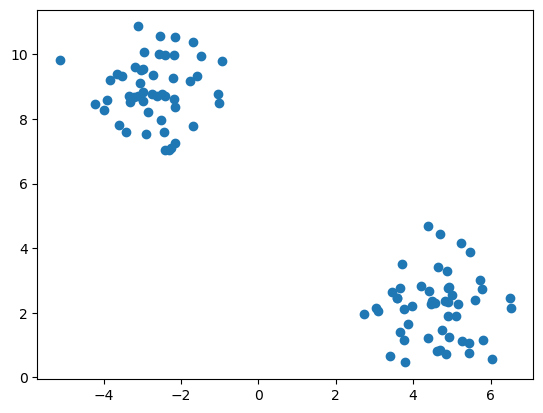

In [12]:
#Plotting the data points 
plt.scatter(X[:,0] , X[:,1])
plt.show()

### Now we shall design our own GMM model using Expectation Maximisation Algorithm

In [13]:
from scipy.stats import multivariate_normal

In [14]:
from matplotlib.patches import Ellipse

def plot_gmm_results(X, means, variances, lamda):
    """
    Visualize GMM clustering results.
    
    Parameters:
        X: np.ndarray
            Input data (num_points, num_features).
        means: np.ndarray
            Cluster means (k, num_features).
        variances: np.ndarray
            Cluster variances (k, num_features).
        lamda: np.ndarray
            Responsibility matrix (num_points, k).
    """
    num_points, num_features = X.shape
    k = means.shape[0]
    
    # Assign clusters based on the maximum responsibility
    cluster_assignments = np.argmax(lamda, axis=1)
    
    # Create a scatter plot of data points
    plt.figure(figsize=(10, 8))
    for cluster in range(k):
        points_in_cluster = X[cluster_assignments == cluster]
        plt.scatter(
            points_in_cluster[:, 0], 
            points_in_cluster[:, 1], 
            label=f"Cluster {cluster+1}", 
            alpha=0.6
        )
        
        # Plot cluster means
        plt.scatter(
            means[cluster, 0], 
            means[cluster, 1], 
            color='red', 
            marker='x', 
            s=200, 
            label=f"Mean {cluster+1}"
        )
        
        # Plot covariance ellipse
        if num_features == 2:  # Ellipses only make sense for 2D data
            cov_matrix = np.diag(variances[cluster])
            draw_covariance_ellipse(means[cluster], cov_matrix)
    
    plt.title("GMM Clustering Results")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def draw_covariance_ellipse(mean, cov_matrix, ax=None, n_std=1.0, **kwargs):
    """
    Draw an ellipse representing the covariance matrix.

    Parameters:
        mean: np.ndarray
            Mean of the cluster (2,).
        cov_matrix: np.ndarray
            Covariance matrix of the cluster (2, 2).
        ax: matplotlib.axes.Axes, optional
            Axis to plot on. Creates one if not provided.
        n_std: float, optional
            Number of standard deviations to plot.
    """
    if ax is None:
        ax = plt.gca()

    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues)

    # Create an ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ellipse.set_alpha(0.4)
    ax.add_patch(ellipse)

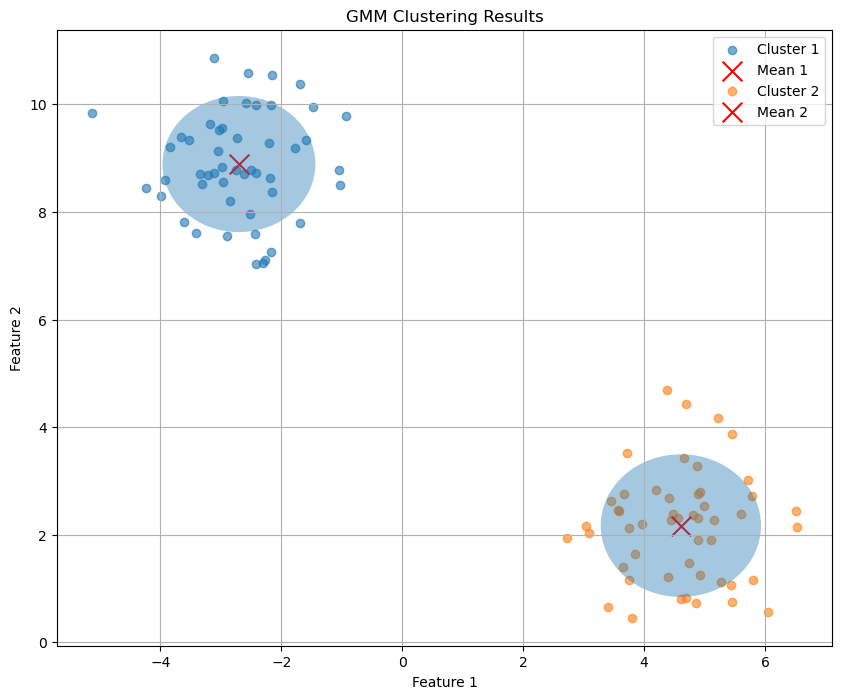

In [15]:
def GMM(X , k=2 , tol=1e-6):
    '''
    Expectation Step : Fixing the Values of lambda, we optimise on the model parameters 
    We obatin the values of , Class mean for each class , Class variance for each class , Probability Pi
    for each class
    '''
    num_points = X.shape[0]
    
    # define the params
    means = X[np.random.choice(X.shape[0], k, replace=False)]
    variances = np.random.rand(k, X.shape[1]) + 1e-6 # Ensure positive variances
    Pis = np.zeros(k)
    
    for i in range(k):
        Pis[i] = random.choice(range(1,100))
    Pis/= np.sum(Pis)  # Normalize to sum to 1
    
    old_means = np.copy(means)
    Convergence = False 
    
    while not Convergence:      
        # Expectation Step 
        lamda = np.zeros((num_points, k))
        for j in range(k):
            covariance = np.diag(variances[j])
            lamda[:, j] = multivariate_normal.pdf(X, mean=means[j], cov=covariance)
            lamda[:, j] *= Pis[j]

        lamda/= np.sum(lamda , axis=1 , keepdims=True) + 1e-8  # Add epsilon for stability

        # Maximisation Step 
        for j in range(k):
            weighted_sum = np.sum(lamda[:, j].reshape(-1, 1) * X, axis=0)
            means[j] = weighted_sum/np.sum(lamda[:, j])

        for j in range(k):
            weighted_squared_diff = lamda[:, j] * np.sum((X - means[j]) ** 2, axis=1)
            variances[j] = np.sum(weighted_squared_diff) / np.sum(lamda[:, j])

        for j in range(k):
            sum = 0
            for i in range(num_points):
                sum += lamda[i][j]
            Pis[j] = sum/num_points 
        
        if np.allclose(means, old_means, atol=tol):
            Convergence = True 
        else : old_means = np.copy(means)
        
    return (means , variances , lamda)

# print(GMM(X)[0]) # the means 
# print(GMM(X)[1]) # the variances 

means , variances , lamda = GMM(X)
plot_gmm_results(X ,means, variances , lamda)